In [1]:
from coffea.nanoevents import NanoEventsFactory
from coffea.nanoevents.schemas import NanoAODSchema,UHH2NtupleSchema


In [2]:
import uproot

In [3]:
#fname = "root://eoscms.cern.ch//eos/cms/store/group/phys_higgs/cmshmm/amarini/ZBBWPMJJjj_EWK_LO_TuneCP5_13TeV-madgraph-pythia8/UL2016-NANOAODSIMv9/211029_131119/0001/step7_1992.root"
fname = "step7_10.root"

In [4]:
events = NanoEventsFactory.from_root(fname,treepath="Events").events()

In [9]:


events.FatJet.pt

<Array [[], [], [273, 234], ... [], [], [174]] type='500 * var * float32[paramet...'>

In [5]:
for p in events.GenPart[0]:
    if(p.status in range(20,30,1)):# and abs(p.pdgId) in [23,24]):
        print(p.pdgId,p.pt,p.status)
        

-5 0.0 21
2 0.0 21
-6 51.25 22
24 28.25 22
2 34.5 23
-24 48.625 22
-5 55.0 23
2 32.875 23
-1 34.75 23
3 68.25 23
-4 24.25 23


In [39]:
events.LHEPart[0].status

<Array [-1, -1, 1, 1, 1, 1, 1, 1] type='8 * int32[parameters={"__doc__": "LHE pa...'>

In [48]:
events.LHEPart[0].pdgId

<Array [5, 2, 5, -5, 2, -1, 1, 5] type='8 * int32[parameters={"__doc__": "PDG ID...'>

In [ ]:
events.LHEPart[0].pdgId

In [44]:
events.LHEPart[0].pt.to_list()

[0.0,
 0.0,
 76.0703125,
 36.94921875,
 108.82421875,
 22.21484375,
 265.203125,
 225.4140625]

In [30]:
list(range(20,30,1))

[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]

In [44]:
#results = "/afs/desy.de/user/a/albrechs/xxl/af-cms/VBS/VBSAnalysisNote.coffea"
results = "VBSAnalysisNote.coffea"

In [53]:
from coffea.util import load
output = load(results)

In [58]:
output['JJ_mJJ500'].to_hist()

Hist(
  StrCategory(['WPJJWMJJjj_EWK_LO_UL2017'], name='dataset', label='Dataset'),
  Regular(60, 0, 3000, name='mass', label='$m_{JJ}$ [GeV]'),
  Regular(60, 0, 3000, name='pt', label='$p_{T,JJ}$ [GeV]'),
  Regular(60, -6, 6, name='eta', label='$\\eta_{JJ}$ [GeV]'),
  storage=Double()) # Sum: 56.0 (58.0 with flow)

<AxesSubplot:xlabel='$m_{leading Ak8}$ [GeV]', ylabel='Events'>

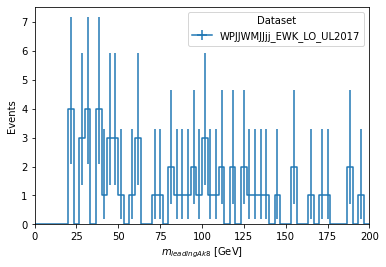

In [59]:
from coffea import hist
hist.plot1d(output['J0'].integrate('eta').integrate('pt'))

<AxesSubplot:xlabel='$m_{JJ}$ [GeV]', ylabel='Events'>

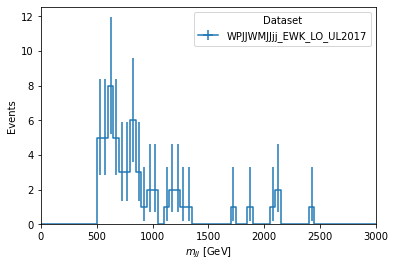

In [67]:
hist.plot1d(output['JJ_mJJ500'].integrate("eta").integrate("pt"))

In [1]:
from dask_jobqueue import HTCondorCluster
from distributed import Client
from dask.distributed import performance_report
import os

In [2]:
from coffea.util import save
from coffea import processor


In [3]:

_x509_path='/afs/desy.de/user/a/albrechs/.globus/voms.dat'
    
env_extra = []
condor_extra = []
env_extra = [
    'export XRD_RUNFORKHANDLER=1',
    'export XRD_STREAMTIMEOUT=10',
    f'export X509_USER_PROXY={_x509_path}',
    f'export X509_CERT_DIR=/cvmfs/grid.cern.ch/etc/grid-security/certificates:{os.environ["X509_CERT_DIR"]}',
    f"export PYTHONPATH=$PYTHONPATH:{os.getcwd()}",
    #f'source {os.environ["HOME"]}/.bashrc',
]
condor_extra = [
f'source {os.environ["HOME"]}/.bashrc',
]
    



In [4]:
cluster = HTCondorCluster(
    cores     =  4,
    memory    =  '4GB',
    disk      =  '4GB',
    env_extra =  env_extra,
    job_extra={
            'log': 'dask_job_output.log',
            'output': 'dask_job_output.out',
            'error': 'dask_job_output.err',
            #'should_transfer_files': 'Yes',
            #'when_to_transfer_output': 'ON_EXIT',
            'getenv':'True'
            },
    #shebang="/bin/bash",
)
        

In [5]:
print(cluster.job_script())

#!/usr/bin/env condor_submit

MY.DaskWorkerName = "htcondor--$F(MY.JobId)--"
RequestCpus = MY.DaskWorkerCores
RequestMemory = floor(MY.DaskWorkerMemory / 1048576)
RequestDisk = floor(MY.DaskWorkerDisk / 1024)
MY.JobId = "$(ClusterId).$(ProcId)"
MY.DaskWorkerCores = 4
MY.DaskWorkerMemory = 4000000000
MY.DaskWorkerDisk = 4000000000
log = dask_job_output.log
output = dask_job_output.out
error = dask_job_output.err
getenv = True

Environment = "XRD_RUNFORKHANDLER=1 XRD_STREAMTIMEOUT=10 X509_USER_PROXY=/afs/desy.de/user/a/albrechs/.globus/voms.dat X509_CERT_DIR=/cvmfs/grid.cern.ch/etc/grid-security/certificates:/afs/desy.de/user/a/albrechs/miniconda3/envs/vbs/etc/grid-security/certificates PYTHONPATH=$PYTHONPATH:/afs/desy.de/user/a/albrechs/xxl/af-cms/UHH2/10_6_28/CMSSW_10_6_28/src/UHH2/python"
Arguments = "-c 'pwd;/afs/desy.de/user/a/albrechs/miniconda3/envs/coffea/bin/python -m distributed.cli.dask_worker tcp://131.169.168.76:33171 --nthreads 1 --nprocs 4 --memory-limit 0.93GiB --name dum

In [21]:
#cluster.adapt(minimum=16)
client = Client(cluster)
client.wait_for_workers(1)

In [58]:

#cluster.adapt(minimum=6)
#client = Client(cluster)
#client.wait_for_workers(1)

In [9]:
client = Client(cluster)

In [22]:
client

<Client: 'tcp://131.169.168.76:33171' processes=16 threads=16, memory=14.88 GiB>

In [23]:
client.wait_for_workers(1)

In [24]:
def print_message():
    import numpy as np
    return np.random.randint(10)

In [25]:
print_message()

1

In [26]:
client.run(print_message)

{'tcp://131.169.77.143:35759': 0,
 'tcp://131.169.77.143:40362': 6,
 'tcp://131.169.77.143:40896': 0,
 'tcp://131.169.77.143:45408': 5,
 'tcp://131.169.77.150:38828': 9,
 'tcp://131.169.77.150:42732': 5,
 'tcp://131.169.77.150:43695': 4,
 'tcp://131.169.77.150:46349': 6,
 'tcp://131.169.77.45:34207': 5,
 'tcp://131.169.77.45:34837': 3,
 'tcp://131.169.77.45:34934': 1,
 'tcp://131.169.77.45:40366': 4,
 'tcp://131.169.77.61:33503': 3,
 'tcp://131.169.77.61:33821': 5,
 'tcp://131.169.77.61:34040': 9,
 'tcp://131.169.77.61:40883': 9}

In [27]:
client.close()

In [28]:
del client

In [29]:
del cluster